# This is a pipeline to visualize and analyze the results of CellProfiler on RNAprobe experiments

In [1]:
# Import stuff
import os
from utils import data_reader
from utils import plot_utils
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from ggplot import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


/home/hmvergara/anaconda3/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/hmvergara/anaconda3/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/hmvergara/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Select the path where the data is (the output of CellProfiler)
GenPath = os.getcwd()
CPoutput_path = GenPath + '/data/'

CPoutput_path = '/mnt/c/Users/herny/Desktop/SWC/Data/Pdym_cell_types/RNAscope/Quantification/2018-09-13/'
# order of the channels and names
channellist = ['mCherry', 'D2', 'D1']

In [3]:
# Import the data
# Name of the output file
nuc_file = 'Nuclei.csv'
# Read it in a useful format
# How many probes have you counted dots for? (do not include DAPI)
NumberOfChannels = 3
CPdata = data_reader.data_reader(CPoutput_path+nuc_file, NumberOfChannels)

In [4]:
# Check data structure
CPdata.tail()

,ObjectNumber,Children_FinalDots_C2_Count,Children_FinalDots_C3_Count,Children_FinalDots_C4_Count,Location_Center_X,Location_Center_Y
4198,4199,17,0,31,3431.181260,10880.018963
4199,4200,0,0,0,7841.298470,10872.593634
4200,4201,1,20,1,3119.058072,10875.041812
4201,4202,8,1,17,2837.531685,10882.465224
4202,4203,2,0,4,3535.310828,10889.391083


In [5]:
# Look at CellProfiler image output
CPout_image_name = 'ResultOverlay.tiff'
img = Image.open(CPoutput_path+CPout_image_name)
img

/home/hmvergara/anaconda3/lib/python3.5/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (89764960 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [6]:
# Define channel names
channels = ['Children_FinalDots_C2_Count','Children_FinalDots_C3_Count','Children_FinalDots_C4_Count']

/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


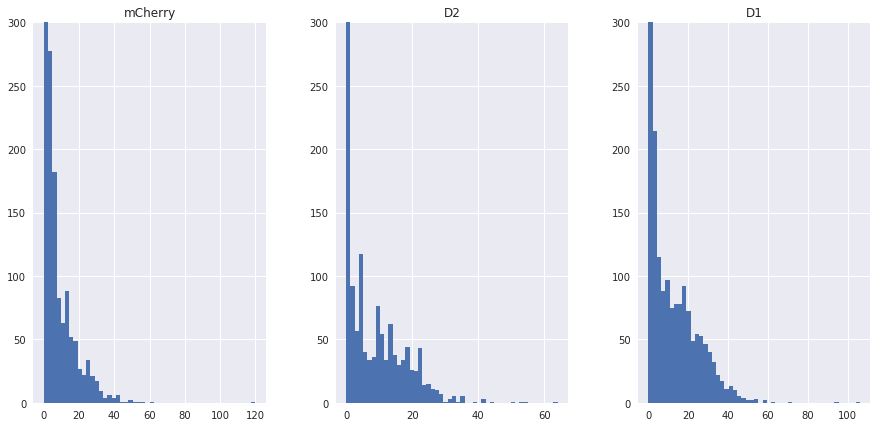

In [7]:
# plot histograms
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,7))
axArr = [ax1, ax2, ax3]
i = 0
for axis in axArr:
    CPdata.hist(channels[i], ax = axis, bins=50)
    #axis.set_yscale("log")
    axis.set_ylim(0,300)
    axis.set_title(channellist[i])
    i+=1

/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


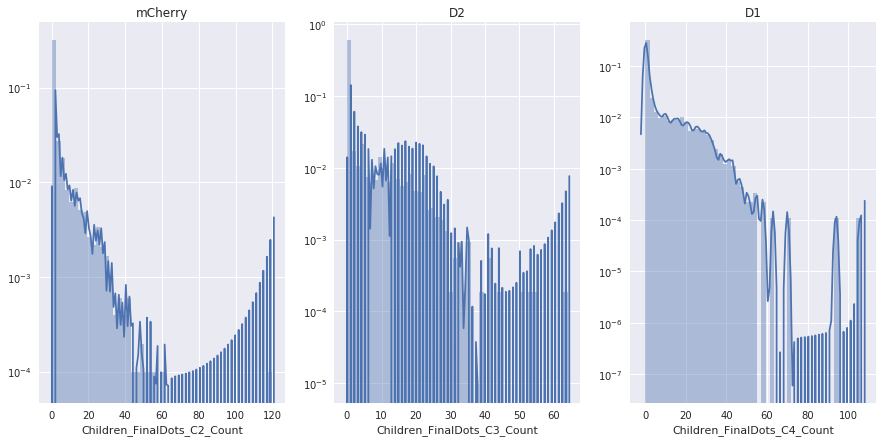

In [8]:
# plot histograms
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,7))
axArr = [ax1, ax2, ax3]
i = 0
for axis in axArr:
    sns.distplot(CPdata[channels[i]], ax = axis)
    axis.set_yscale("log")
    axis.set_title(channellist[i])
    i+=1

/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


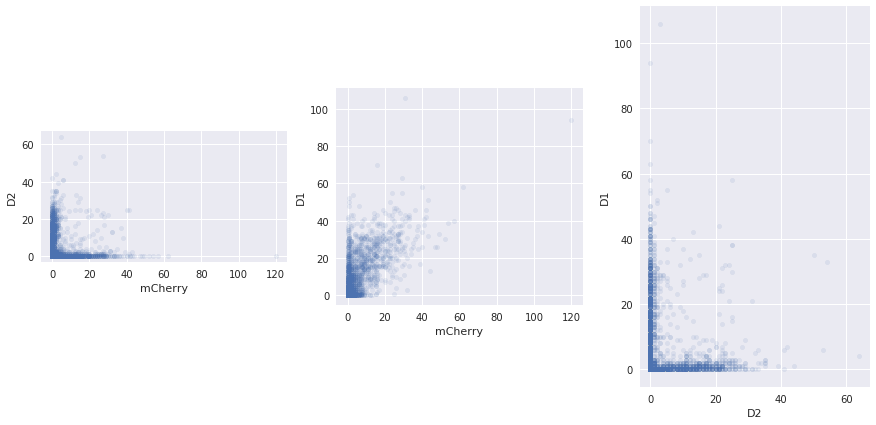

In [9]:
# plot channel combinations
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,7))
axArr = [ax1, ax2, ax3]
poscomb = [[0,1],[0,2],[1,2]] #possible channels combinations
k = 0
for i,j in poscomb:
    CPdata.plot.scatter(channels[i],channels[j], ax = axArr[k], alpha = 0.1)
    axArr[k].set_xlabel(channellist[i])
    axArr[k].set_ylabel(channellist[j])
    axArr[k].set_aspect('equal')
    k+=1

In [10]:
# Create cutoffs based on the plots to classify cells as positive for either channels
# Make a matrix with 0s and 1s as an easy way to quantify and plot
CutOff = 5
BinMat = CPdata[channels] > CutOff

# Measure combinations
labels = 'mCh+,D1-,D2-', 'mCh+,D1+,D2-', 'mCh+,D1-,D2+', 'mCh+,D1+,D2+'

# Cells possitive for channel 0
C0Pos = BinMat[BinMat[channels[0]]] == True
C0PosCellsID = set(C0Pos.index)
# Cells possitive for channel 1
C1Pos = BinMat[BinMat[channels[1]]] == True
C1PosCellsID = set(C1Pos.index)
# Cells possitive for channel 2
C2Pos = BinMat[BinMat[channels[2]]] == True
C2PosCellsID = set(C2Pos.index)

comb4 = (C0PosCellsID & C1PosCellsID & C2PosCellsID)
comb3 = (C0PosCellsID & C1PosCellsID - C2PosCellsID)
comb2 = (C0PosCellsID & C2PosCellsID - C1PosCellsID)
comb1 = (C0PosCellsID - C1PosCellsID - C2PosCellsID)

/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


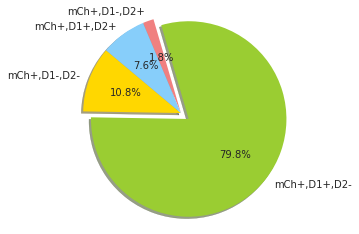

In [11]:
# Create a Pie Chart

# Data to plot
sizes = [len(comb1), len(comb2), len(comb3), len(comb4)]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0, 0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

/home/hmvergara/anaconda3/lib/python3.5/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (89764960 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


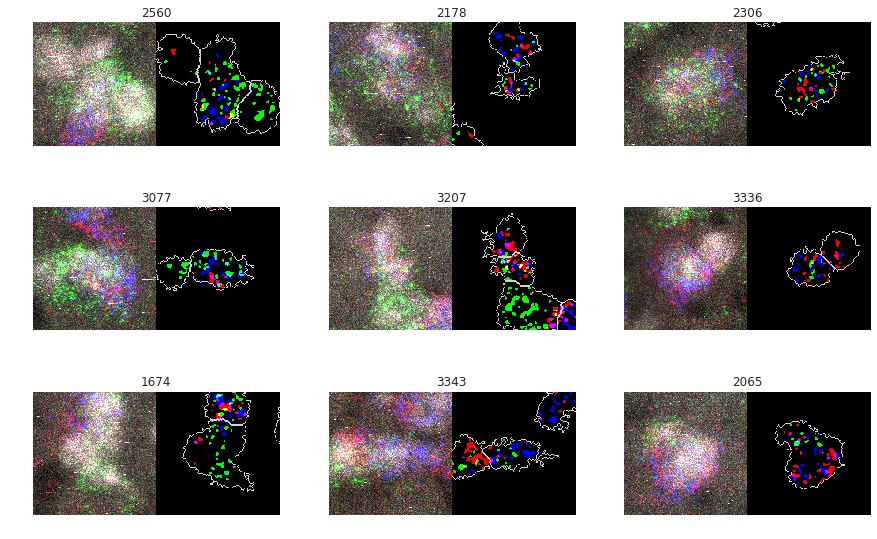

In [12]:
# plot samples of these combinations
# original image name
Orig_image_name = 'OriginalOverlay.tiff'
img2 = Image.open(CPoutput_path+Orig_image_name)

NumOfSamples = 9
combToPlot = list(comb4)
if NumOfSamples > len(combToPlot):
    #update if needed
    NumOfSamples = len(combToPlot) 
NumOfSamples
fig = plt.subplots(sharey=False, figsize=(15,30))
for i in range(1,(NumOfSamples+1)): # make random without reinsertion
    # write here the cell number
    cellNum = combToPlot[i-1]
    test = plot_utils.see_object(cellNum,CPdata,img,img2,70)
    plt.subplot(NumOfSamples, 3, i)
    plt.grid(False)
    plt.axis('off')
    plt.title(cellNum)
    plt.imshow(test)


In [15]:
# quantify the number of cells positive for the combinations of probes
# channels alone and combinations
# Bar Plot

# Venn Diagram?

In [16]:
# pca plot from https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
pca = PCA(n_components=2)
pca_result = pca.fit_transform(CPdata[channels].values)
print ('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [ 0.68085104  0.22336966]


/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


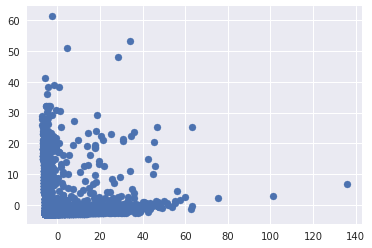

In [17]:
plt.scatter(pca_result[:,0],pca_result[:,1])

/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


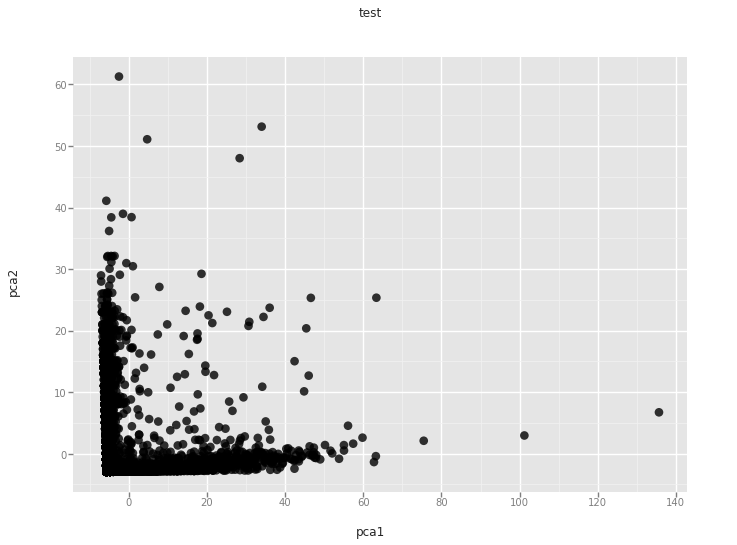

<ggplot: (-9223363302944491411)>

In [18]:
PCA_df = pd.DataFrame(pca_result,columns=['pca1', 'pca2'])

chart = ggplot( PCA_df, aes(x='pca1', y='pca2') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("test")
chart

In [19]:
# tsne plot
df_for_tsne = CPdata.copy()
#optional: do it only on the data that are included in the pie-chart categories:
df_for_tsne = CPdata.loc[frozenset(comb1.union(comb2,comb3,comb4))].copy()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_for_tsne[channels].values)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 609 / 609
[t-SNE] Mean sigma: 2.835386
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.515457
[t-SNE] Error after 300 iterations: 0.515457


/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


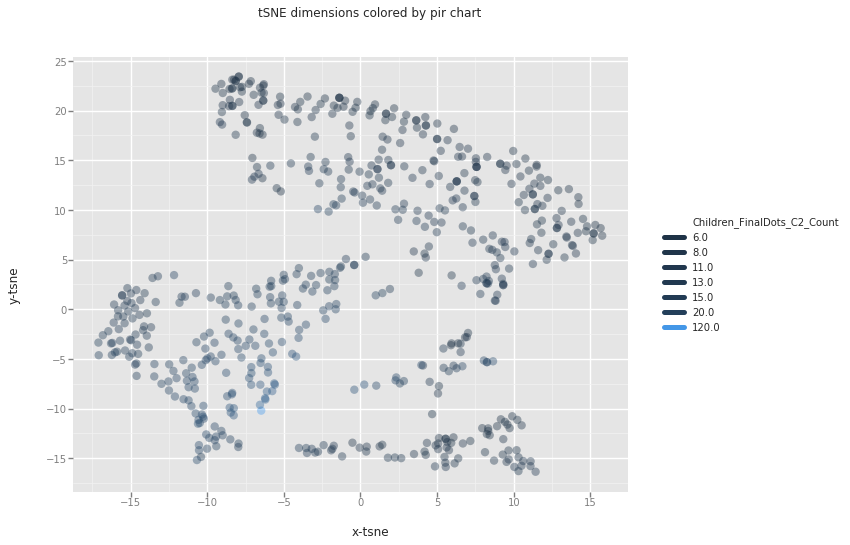

<ggplot: (-9223363302962736682)>

In [23]:
df_tsne = df_for_tsne[channels].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

# color them according to the pie chart
df_tsne['label'] = 'none'
df_tsne.loc[ frozenset(comb1), ['label'] ] = labels[0]
df_tsne.loc[ frozenset(comb2), ['label'] ] = labels[1]
df_tsne.loc[ frozenset(comb3), ['label'] ] = labels[2]
df_tsne.loc[ frozenset(comb4), ['label'] ] = labels[3]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.4) \
        + ggtitle("tSNE dimensions colored by pir chart")
chart

In [ ]:
#FROM ANOTHER COPY OF THE NOTEBOOK
df_tsne = df_for_tsne[channels].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

# color them according to the pie chart
df_tsne['label'] = 'none'
df_tsne.loc[ frozenset(comb1), ['label'] ] = labels[0]
df_tsne.loc[ frozenset(comb2), ['label'] ] = labels[1]
df_tsne.loc[ frozenset(comb3), ['label'] ] = labels[2]
df_tsne.loc[ frozenset(comb4), ['label'] ] = labels[3]

# color = 'label'
df_tsne['lg_D1'] = np.log(df_tsne['Children_FinalDots_C4_Count'])
# a bunch of crap to convert -inf to zeros
idx = df_tsne['lg_D1'][np.isinf(df_tsne['lg_D1'])].index
newvector = df_tsne['lg_D1']
newvector.loc[idx] = 0
df_tsne['lg_D1'] = newvector
df_tsne['lg_D1']

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='lg_D1') ) \
        + geom_point(size=70,alpha=0.4) \
        + ggtitle("tSNE dimensions colored by pir chart")
chart

In [22]:
# df_tsne = df_tsne[list(df_tsne.columns.values)[0:6]]
df_tsne.head()


,Children_FinalDots_C2_Count,Children_FinalDots_C3_Count,Children_FinalDots_C4_Count,x-tsne,y-tsne,label
4096,9,0,14,7.530589,15.190880,"mCh+,D1+,D2-"
2052,8,0,13,6.468364,16.331750,"mCh+,D1+,D2-"
6,8,0,6,-1.836004,19.676295,"mCh+,D1+,D2-"
2056,7,0,6,-1.739267,20.498131,"mCh+,D1+,D2-"
4104,15,0,28,-15.150582,-0.225457,"mCh+,D1+,D2-"


In [81]:
list(df_tsne["label_numeric"]).count(4)

7

In [ ]:
# plot in 3D the three axis
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(CPdata[channels[0]],CPdata[channels[1]],CPdata[channels[2]], alpha=0.1)
ax.set_xlabel(channellist[0])
ax.set_ylabel(channellist[1])
ax.set_zlabel(channellist[2])


plt.show()

/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


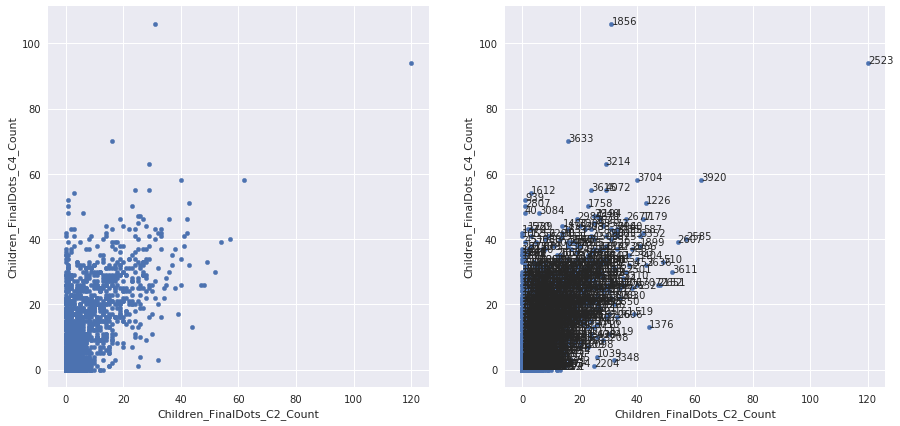

In [21]:
# plot the data to select cells
channel1 = 0
channel2 = 2
%matplotlib inline
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,7))
CPdata.plot.scatter(channels[channel1],channels[channel2], ax = ax)
ax3 = CPdata.plot(channels[channel1], channels[channel2], kind='scatter', ax = ax2)
CPdata[[channels[channel1],channels[channel2],'ObjectNumber']].apply(lambda x: ax3.text(*x),axis=1);

# create a density plot
# change labels

In [ ]:
# Show zoomed images (both the original and the processed image) depending on the object selected

# original image name
Orig_image_name = 'OriginalOverlay.tiff'
img2 = Image.open(CPoutput_path+Orig_image_name)

# write here the cell number
cellNum = 3920

test = plot_utils.see_object(cellNum,CPdata,img,img2,100)
test

In [7]:
CPdata.shape[0]

4203